# SFRC Chatbot
This RAG chatbot serves to address any queries related to steel fibre reinforced concrete (SFRC). The knowledge bank includes official Singapore Standard design code, characterisation test code, and LTA Particular Specifications:

- ACES Design Guide FRC (SS 674-2021) 2022
- SS 674-2021
- LTA-PS-CRL2-Cluster2
    - PS Clause 09_Design Requirements
    - PS App XX_SFRC Cast In-situ Structure
    - PS Clause XX - SFRC Segmental Lining
- QAQC document
    - EN14651
    - EN14721
    - UNE 83515

<b>Changes made to improved RAG chain:</b>
- Pre-retrieval
    - Preprocess documents to remove useless pages & content (done)
    - Group pages together by documents, then perform semantic chunking (done)
    - Tag semantic chunks with page number (done; tried 3 methods - compare string, vector search, keyword search -- keyword search is the best!)
- Retrieval
    - Hybrid Search - semantic search & keyword search (done) <br>
https://superlinked.com/vectorhub/articles/optimizing-rag-with-hybrid-search-reranking
    - Cross encoder reranking with COHERE API (done)
    - Reorder retrieved documents to mitigate lost-in-the-middel effect (done)

<b> Other Important Tasks performed in this Notebook: </b>
- Evaluation
    - Generate synthetic Q&A set with 100 Q&A pairs (done)
    - Perform manual QC on the synthetic Q&A set, and manually add on critical questions that are missing (done)
    - Use RAGAS to objectively evaluate the perfomance of naive RAG vs improved RAG via the metric - answer correctness <br>
https://docs.ragas.io/en/stable/getstarted/evaluation.html <br>
https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html
- GUI
    - Streamlit chatbot template (done)


<b>KIV:</b>
- Error Analysis (identify questions where Naive RAG outperform Improved RAG - & find out WHY) 
- Compare with AIBots and VICA (consider using Selenium to compile chatbot response)
- minilm huggingface for reranking <br>
https://huggingface.co/cross-encoder/ms-marco-MiniLM-L-6-v2
- omit header & footer from docs

## Set-up

In [1]:
# This function is for calculating the tokens given the "message"

import tiktoken

def count_tokens(text):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    return len(encoding.encode(text))

In [2]:
# This function returns a specific page from a specific file (to better understand how to split & chunk the document)

def find_document(list_of_documents_loaded, file_path,page_num):
    for document in list_of_documents_loaded:
        if (document.metadata['source']==file_path) and (document.metadata['page']==page_num):
            return document

In [3]:
import chromadb

# This function returns all existing collection stored within a given database
def print_existing_collections(path="../output/vector_db"):
    client = chromadb.PersistentClient(path)
    for collection in client.list_collections():
        print(collection.name)
        
# This function deletes an existing collection of a given name that is stored within a given database
def delete_existing_collections(name, path="../output/vector_db"):
    client = chromadb.PersistentClient(path)
    client.delete_collection(name) 


In [4]:
# Setting up Credentials & Common Components for LangChain

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
import os
from dotenv import load_dotenv 

# Pass OPEN_API_KEY to the environment
load_dotenv(override=True)  # To allow overriding of environment variables with updated .env file
# load_dotenv()
# print(os.environ["OPENAI_API_KEY"])

# embedding model that we will use for the session
embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')

# llm to be used in RAG pipeplines in this notebook
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0, seed=42)

## 1. Naive RAG

### Import Dependencies and Setting up

In [79]:
# Importing Dependencies and Setting up

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

### Load Document

In [80]:
### Document Loading

from langchain_community.document_loaders import PyPDFLoader
import os

# compile list of filenames to load
file_paths = []
folder_path = '../data'
# to list all foldernames & filenames within a given directory
# ignore hidden files and "excluded" folders
for dirpath, dirnames, filenames in os.walk("../data", topdown=True):
    dirnames[:] = [d for d in dirnames if not d.endswith("[excluded]")]
    for f in filenames:
        if (not f.startswith(".")) and (f.endswith(".pdf")) and (not f.endswith("[excluded].pdf")) :
            file_path = os.path.join(dirpath,f)
            print(f"Adding files {file_path}")
            file_paths.append(file_path)

# load the documents
list_of_documents_loaded = []
for file_path in file_paths:
    try:
        # try to load the document
        loader = PyPDFLoader(file_path)

        # load() returns a list of Document objects
        data = loader.load()
        # use extend() to add to the list_of_documents_loaded
        list_of_documents_loaded.extend(data)
        print(f"Loaded {file_path}")

    except Exception as e:
        # if there is an error loading the document, print the error and continue to the next document
        print(f"Error loading {file_path}: {e}")
        continue

print('')
print("Total documents loaded:", len(list_of_documents_loaded))

Adding files ../data/SS 674-2021.pdf
Adding files ../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf
Adding files ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf
Adding files ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf
Adding files ../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf
Adding files ../data/QAQC/EN14721.pdf
Adding files ../data/QAQC/EN14651.pdf
Adding files ../data/QAQC/prUNE 83515.pdf
Loaded ../data/SS 674-2021.pdf
Loaded ../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf
Loaded ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf
Loaded ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf
Loaded ../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf
Loaded ../data/QAQC/EN

In [81]:
list_of_documents_loaded

[Document(metadata={'source': '../data/SS 674-2021.pdf', 'page': 0}, page_content=' \n \n \n \n \n   \n   \n \n \n \n \nSS 674 :2021  \nSS 812310:2014, MOD   \n (ICS 91.080.40; 91.100.30 ) \n  \n \n \n \n \n \n \n \n \n \n \n \nSINGAPORE S TANDARD   \nFibre concrete – Design of fibre concrete \nstructures  \n \n \n \n Single user licence only, no reproduction or circulation. Copying and networking prohibited Licensed to Er. Zhang Bin, Member, WG on SS 674, compliments of Enterprise Singapore '),
 Document(metadata={'source': '../data/SS 674-2021.pdf', 'page': 1}, page_content=' \n SS 674:2021   \nSS 812310:2014, MOD     \n(ICS 91.080.40; 91.100.30 )  \n \nSINGAPORE STANDARD  \nFibre concrete – Design of fibre concrete structures  \n \nPublished by Enterprise Singapore  \nAll rights reserved . Unles s otherwis e specified , no part of this Singapore Standard may \nbe reproduced or utilised in any form or by any means,  electroni c or mechanical , includin g \nphotocopyin g and microfilm

#### Find a specific page from a specific loaded document

In [8]:
for i, file_path in enumerate(file_paths):
    print(f"{i}: {file_path}")

0: ../data/SS 674-2021.pdf
1: ../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf
2: ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf
3: ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf
4: ../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf
5: ../data/QAQC/EN14721.pdf
6: ../data/QAQC/EN14651.pdf
7: ../data/QAQC/prUNE 83515.pdf


In [9]:
file_path = file_paths[2]
page_num = 5

document = find_document(list_of_documents_loaded, file_path, page_num)
print(document) 

page_content='PS-23-5 
CONTRACT CR206 25.4.3.3 Polypropylene fibres shall have a melting point of 160°C ± 10%. 25.4.3.4 The polypropylene fibres shall be selected based on compliance with this Specification and suitability to Contractor’s proposed batching, mixing and concrete placement processes, as demonstrated by trials. 25.4.3.5 Polypropylene fibres shall be supplied in water soluble bags. Each bag shall contain 1.0kg of polypropylene fibres. 25.4.3.6 The minimum polypropylene fibre dosage shall be 1.0kg/m3. 25.4.4 The steel and polypropylene fibres shall be stored in dry-sealed containers until required for use. The surface of fibres should be kept dry and clean with no corrosion, grease, dirt, mill scale and deleterious materials that may reduce the bond between the fibres and the concrete. 25.5 Design Mix and Workability 25.5.1 The SFRC design mix shall be tailored to achieve all the specified requirements on concrete properties, water penetration and workability. 25.5.2 The SFR

#### Count tokens in each document

In [10]:
# Count tokens in each document
i = 0
for doc in list_of_documents_loaded:
    i += 1
    print(f'Document {i} - "{doc.metadata.get("source")}" has {count_tokens(doc.page_content)} tokens')

print('')
print("Total documents loaded:", len(list_of_documents_loaded))

Document 1 - "../data/SS 674-2021.pdf" has 103 tokens
Document 2 - "../data/SS 674-2021.pdf" has 203 tokens
Document 3 - "../data/SS 674-2021.pdf" has 500 tokens
Document 4 - "../data/SS 674-2021.pdf" has 489 tokens
Document 5 - "../data/SS 674-2021.pdf" has 228 tokens
Document 6 - "../data/SS 674-2021.pdf" has 912 tokens
Document 7 - "../data/SS 674-2021.pdf" has 813 tokens
Document 8 - "../data/SS 674-2021.pdf" has 727 tokens
Document 9 - "../data/SS 674-2021.pdf" has 437 tokens
Document 10 - "../data/SS 674-2021.pdf" has 650 tokens
Document 11 - "../data/SS 674-2021.pdf" has 643 tokens
Document 12 - "../data/SS 674-2021.pdf" has 546 tokens
Document 13 - "../data/SS 674-2021.pdf" has 576 tokens
Document 14 - "../data/SS 674-2021.pdf" has 637 tokens
Document 15 - "../data/SS 674-2021.pdf" has 636 tokens
Document 16 - "../data/SS 674-2021.pdf" has 409 tokens
Document 17 - "../data/SS 674-2021.pdf" has 550 tokens
Document 18 - "../data/SS 674-2021.pdf" has 331 tokens
Document 19 - "../d

### Splitting and Chunking

In [82]:
### Splitting and Chunking

# This is to ensure that we can process the document in smaller chunks
# This is especially useful for long documents that may exceed the token limit
# or to keep the chunks smaller, so each chunk is more focused
from langchain_text_splitters import RecursiveCharacterTextSplitter

# In this case, we intentionally set the chunk_size to 1100 tokens, to have the smallest document (document 2) intact
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=20, length_function=count_tokens)

# Split the documents into smaller chunks
splitted_documents = text_splitter.split_documents(list_of_documents_loaded)

# Print the number of documents after splitting
print(f"Number of documents after splitting: {len(splitted_documents)}")

Number of documents after splitting: 217


In [83]:
splitted_documents

[Document(metadata={'source': '../data/SS 674-2021.pdf', 'page': 0}, page_content='SS 674 :2021  \nSS 812310:2014, MOD   \n (ICS 91.080.40; 91.100.30 ) \n  \n \n \n \n \n \n \n \n \n \n \n \nSINGAPORE S TANDARD   \nFibre concrete – Design of fibre concrete \nstructures  \n \n \n \n Single user licence only, no reproduction or circulation. Copying and networking prohibited Licensed to Er. Zhang Bin, Member, WG on SS 674, compliments of Enterprise Singapore'),
 Document(metadata={'source': '../data/SS 674-2021.pdf', 'page': 1}, page_content='SS 674:2021   \nSS 812310:2014, MOD     \n(ICS 91.080.40; 91.100.30 )  \n \nSINGAPORE STANDARD  \nFibre concrete – Design of fibre concrete structures  \n \nPublished by Enterprise Singapore  \nAll rights reserved . Unles s otherwis e specified , no part of this Singapore Standard may \nbe reproduced or utilised in any form or by any means,  electroni c or mechanical , includin g \nphotocopyin g and microfilming,  without  permission  in writing  fro

#### Find a specific page from a specific split document

In [13]:
for i, file_path in enumerate(file_paths):
    print(f"{i}: {file_path}")

0: ../data/SS 674-2021.pdf
1: ../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf
2: ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf
3: ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf
4: ../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf
5: ../data/QAQC/EN14721.pdf
6: ../data/QAQC/EN14651.pdf
7: ../data/QAQC/prUNE 83515.pdf


In [14]:
file_path = file_paths[2]
page_num = 5

document = find_document(splitted_documents, file_path, page_num)
print(document)

page_content='PS-23-5 
CONTRACT CR206 25.4.3.3 Polypropylene fibres shall have a melting point of 160°C ± 10%. 25.4.3.4 The polypropylene fibres shall be selected based on compliance with this Specification and suitability to Contractor’s proposed batching, mixing and concrete placement processes, as demonstrated by trials. 25.4.3.5 Polypropylene fibres shall be supplied in water soluble bags. Each bag shall contain 1.0kg of polypropylene fibres. 25.4.3.6 The minimum polypropylene fibre dosage shall be 1.0kg/m3. 25.4.4 The steel and polypropylene fibres shall be stored in dry-sealed containers until required for use. The surface of fibres should be kept dry and clean with no corrosion, grease, dirt, mill scale and deleterious materials that may reduce the bond between the fibres and the concrete. 25.5 Design Mix and Workability 25.5.1 The SFRC design mix shall be tailored to achieve all the specified requirements on concrete properties, water penetration and workability. 25.5.2 The SFR

### Generate word embeddings & Store in Chroma database

#### a. Run cell below [if word embeddings have <b><u>ALREADY</u></b> been generated and stored in Chroma database] i.e. dont waste money!!

In [195]:
# retrieve & load saved llm langchain embedding from Chroma database
# i.e. dont waste money!!

vectordb = Chroma(
    embedding_function=embeddings_model,
    collection_name="naive_splitter", # one database can have multiple collections
    persist_directory="../output/vector_db"
)

print(vectordb._collection.count())
print("")
print_existing_collections(path="../output/vector_db")
# delete_existing_collections('xxx', path="../output/vector_db")

217

no_splitter
semantic_splitter
naive_splitter


#### b. Run cell below [only if word embeddings have <b><u>NOT</u></b> been generated and stored in Chroma database]

In [84]:
### Storage

# Create the vector database
vectordb = Chroma.from_documents(
    documents=splitted_documents,
    embedding=embeddings_model,
    collection_name="naive_splitter", # one database can have multiple collections
    persist_directory="../output/vector_db"
)

print(vectordb._collection.count())
print("")
print_existing_collections(path="../output/vector_db")

217

no_splitter
semantic_splitter
naive_splitter


### Retrieval and Output

In [277]:
### Retrieval and Output

# Create the RAG pipeline
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

# Build prompt
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

# Run chain
naive_chain = RetrievalQA.from_chain_type(
    ChatOpenAI(model='gpt-4o-mini', temperature=0),
    retriever=vectordb.as_retriever(search_kwargs={"k": 4}),
    return_source_documents=True, # Make inspection of document possible
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)


### Test out RAG Chain

In [275]:
# Obtain questions from qa-set/additional_questions.json

import json
import os

folder_path = '../output/qa-set'
filename = 'additional_questions.json'
file_path = os.path.join(folder_path, filename)
with open(file_path) as f:
    list_dictionary  = json.load(f)

print(list_dictionary)

[{'question': 'What is Top-P sampling?', 'answer': '', 'context': [], 'ground_truth': "I don't know. Thanks for asking!"}, {'question': 'What is the value of αcc,f?', 'answer': '', 'context': [], 'ground_truth': 'For fibre reinforced concrete without bar reinforcement, the design compressive strength may be taken as: fcd = αcc,f fck/γf (see equation 3.11 from ACES Design Guide) where αcc,f is a coefficient accounting for long term effects and of unfavourable effects due to the way in which the load is applied. The value of αcc,f may be taken as: αcc,f =0.30+0.5fR,3/fR,1 (see equation 3.12 from ACES Design Guide) where 0.60 ≤ αcc,f ≤ 0.85. Based on Table C3.3 summarises the αcc,f for different ductility class and fR,3/fR,1 ratio. Thanks for asking!'}, {'question': 'How to calculate the design compressive strength of sfrc?', 'answer': '', 'context': [], 'ground_truth': 'For fibre reinforced concrete without bar reinforcement, the design compressive strength may be taken as: fcd = αcc,f f

In [276]:
# Query & Answer using Naive RAG chain: 
query = list_dictionary[1]['question']
llm_response = naive_chain.invoke(query)
print(llm_response)


{'query': 'What is the value of αcc,f?', 'result': 'The value of αcc,f depends on the ductility class and the ratio fR,3/fR,1. For ductility class "a," αcc,f is 0.60, and for class "e," it is 0.85. Thanks for asking!', 'source_documents': [Document(metadata={'page': 30, 'source': '../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf'}, page_content='September1, 2022 10:46 RPS\nTable C3.3. Values of αcc,f\nDuctilityClass fR,3/fR,1 αcc,f\na 0.5 0.60\nb 0.7 0.65\nc 0.9 0.75\nd 1.1 0.80\ne 1.3 0.85\n20'), Document(metadata={'page': 29, 'source': '../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf'}, page_content='September1, 2022 10:46 RPS\nMaterialProperties\n 19\nAs a simpli ﬁcation, l cs=125mm may be used. Also, the recommendedvalue of\nεFtudis 0.02.It is notedthatthe abovedoesnotapplytopolymeric ﬁbres.\nThe relation between σcandεcin compression, following prEN 1992-1-1 Eq.\n(5.6), is takenas:\nεc1=0.7f1/3\ncm(1+0.03fR1,k) (C3.13)\nεcu1=kεc1 (C3.14)\nk=1+20\n\x02\n82−2.2fR1,k(C3.15)\

#### Log LLM responses

In [19]:
# save llm langchain response into a .log for future reference
# i.e. dont waste money!!

import logging

# set up logger
logging.basicConfig(
    # filename="stream1.log",
    filename="../output/stream-naive-rag.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    force=True,
)

# do your querying of LLM here
query = llm_response['query']
result = llm_response['result']
documents = llm_response['source_documents']

logging.info(f"\n query: {query} \n result: {result} \n documents: {documents} \n\n")




#### Identify the retrieved documents for a given query

In [20]:
# retrieve & load saved llm langchain embedding from Chroma database
# i.e. dont waste money!!
vectordb_naive_rag = Chroma(
    embedding_function=embeddings_model,
    collection_name="naive_splitter", # one database can have multiple collections
    persist_directory="./vector_db"
)

print(vectordb_naive_rag._collection.count())
print("")

query = list_dictionary[1]['question']
print(query)

# Use the vectorstore (i.e. database containing word embeddings) to see the retrieved documents with the relevance scores
vectordb.similarity_search_with_relevance_scores(query, k=10)


0

What is the value of αcc,f?


[(Document(metadata={'page': 30, 'source': '../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf'}, page_content='September1, 2022 10:46 RPS\nTable C3.3. Values of αcc,f\nDuctilityClass fR,3/fR,1 αcc,f\na 0.5 0.60\nb 0.7 0.65\nc 0.9 0.75\nd 1.1 0.80\ne 1.3 0.85\n20'),
  0.5330156580444474),
 (Document(metadata={'page': 29, 'source': '../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf'}, page_content='September1, 2022 10:46 RPS\nMaterialProperties\n 19\nAs a simpli ﬁcation, l cs=125mm may be used. Also, the recommendedvalue of\nεFtudis 0.02.It is notedthatthe abovedoesnotapplytopolymeric ﬁbres.\nThe relation between σcandεcin compression, following prEN 1992-1-1 Eq.\n(5.6), is takenas:\nεc1=0.7f1/3\ncm(1+0.03fR1,k) (C3.13)\nεcu1=kεc1 (C3.14)\nk=1+20\n\x02\n82−2.2fR1,k(C3.15)\nwhere f cmand fR1,kareinMPa.\n3.4. Design Compressive Strength for FRC withoutbar\nreinforcement\nForﬁbrereinforcedconcretewithoutbarreinforcement,thedesigncompres-sive strengthmay betakenas:\nf\ncd=αcc,ffck/γf (

## 2. Improved RAG

https://playbooks.capdev.govtext.gov.sg/experiments/ <br>
https://abc-notes.data.tech.gov.sg/notes/topic-5-advanced-rag/2.-improving-pre-retrieval-processes.html

### Import Dependencies and Setting up

In [21]:
# Importing Dependencies and Setting up

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
# from langchain_text_splitters import RecursiveCharacterTextSplitter

### Load Document & Preprocess Document

In [22]:
### Document Loading

# from langchain_community.document_loaders import PDFMinerLoader ## pdfminer.six is not as good as PyPDFLoader
from langchain_community.document_loaders import PyPDFLoader
import os

# compile list of filenames to load
file_paths = []
folder_path = '../data'
# to list all foldernames & filenames within a given directory
# ignore hidden files and "excluded" folders
for dirpath, dirnames, filenames in os.walk("../data", topdown=True):
    dirnames[:] = [d for d in dirnames if not d.endswith("[excluded]")]
    for f in filenames:
        if (not f.startswith(".")) and (f.endswith(".pdf")) and (not f.endswith("[excluded].pdf")) :
            file_path = os.path.join(dirpath,f)
            print(f"Adding files {file_path}")
            file_paths.append(file_path)

# load the documents
list_of_documents_loaded = []
for file_path in file_paths:
    try:
        # try to load the document
        loader = PyPDFLoader(file_path)
        # load() returns a list of Document objects
        data = loader.load()
        # use extend() to add to the list_of_documents_loaded
        list_of_documents_loaded.extend(data)
        print(f"Loaded {file_path}")

    except Exception as e:
        # if there is an error loading the document, print the error and continue to the next document
        print(f"Error loading {file_path}: {e}")
        continue

print('')
print("Total documents loaded:", len(list_of_documents_loaded))

Adding files ../data/SS 674-2021.pdf
Adding files ../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf
Adding files ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf
Adding files ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf
Adding files ../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf
Adding files ../data/QAQC/EN14721.pdf
Adding files ../data/QAQC/EN14651.pdf
Adding files ../data/QAQC/prUNE 83515.pdf
Loaded ../data/SS 674-2021.pdf
Loaded ../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf
Loaded ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf
Loaded ../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf
Loaded ../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf
Loaded ../data/QAQC/EN

In [23]:
list_of_documents_loaded

[Document(metadata={'source': '../data/SS 674-2021.pdf', 'page': 0}, page_content=' \n \n \n \n \n   \n   \n \n \n \n \nSS 674 :2021  \nSS 812310:2014, MOD   \n (ICS 91.080.40; 91.100.30 ) \n  \n \n \n \n \n \n \n \n \n \n \n \nSINGAPORE S TANDARD   \nFibre concrete – Design of fibre concrete \nstructures  \n \n \n \n Single user licence only, no reproduction or circulation. Copying and networking prohibited Licensed to Er. Zhang Bin, Member, WG on SS 674, compliments of Enterprise Singapore '),
 Document(metadata={'source': '../data/SS 674-2021.pdf', 'page': 1}, page_content=' \n SS 674:2021   \nSS 812310:2014, MOD     \n(ICS 91.080.40; 91.100.30 )  \n \nSINGAPORE STANDARD  \nFibre concrete – Design of fibre concrete structures  \n \nPublished by Enterprise Singapore  \nAll rights reserved . Unles s otherwis e specified , no part of this Singapore Standard may \nbe reproduced or utilised in any form or by any means,  electroni c or mechanical , includin g \nphotocopyin g and microfilm

#### Preprocess document -- *to update manually*

i.e. remove irrelevant pages such as cover pages, contents pages, etc.

In [24]:
irrelevant_pages = {
    '../data/SS 674-2021.pdf':list(range(7)),
    '../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf':list(range(11)),
    '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf':[0],
    '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf':[],
    '../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf':[0,1],
    '../data/QAQC/EN14721.pdf':[0,1],
    '../data/QAQC/EN14651.pdf':[0,1],
    '../data/QAQC/prUNE 83515.pdf':[],
    }


In [25]:
list_of_processed_docs = []

for doc in list_of_documents_loaded:
    source = doc.metadata['source']
    if doc.metadata['page'] in irrelevant_pages[source]:
        pass
    else:
        list_of_processed_docs.append(doc)

In [26]:
list_of_processed_docs

[Document(metadata={'source': '../data/SS 674-2021.pdf', 'page': 7}, page_content='SS 674 :2021  \n \n7 \nCOPYRIGHT  National Foreword  \n \n \nThis Singapore Standard was prepared by the Working Group on Fibre concrete – Design of fibre \nconcrete structures set up by the Technical Committee on Building Structures and Sub structures under \nthe purview of BCSC.  \n \nThis standard is a modified adoption of  SS 812310:2014, “Fibre concrete – Design of fibre concrete \nstructures” , including its Amendment, published by the Swedish Institute for Standards.  \n \nIn this standard, minor modifications have been made in Tables P.1 and Q.2 due to national \nrequirements and the particular  need s of the local industry. These technical deviations and additional \ninformation have been added directly to the clauses and are marked by a vertical bar on the left margin \nof the standard. The modifications are  as follows :  \n  \na) Modification o f requirements for Table P.1 – Properties to be 

#### Count tokens in each document

In [27]:
# Count tokens in each document
i = 0
for doc in list_of_documents_loaded:
    i += 1
    print(f'Document {i} - "{doc.metadata.get("source")}" has {count_tokens(doc.page_content)} tokens')

print('')
print("Total documents loaded:", len(list_of_documents_loaded))

Document 1 - "../data/SS 674-2021.pdf" has 103 tokens
Document 2 - "../data/SS 674-2021.pdf" has 203 tokens
Document 3 - "../data/SS 674-2021.pdf" has 500 tokens
Document 4 - "../data/SS 674-2021.pdf" has 489 tokens
Document 5 - "../data/SS 674-2021.pdf" has 228 tokens
Document 6 - "../data/SS 674-2021.pdf" has 912 tokens
Document 7 - "../data/SS 674-2021.pdf" has 813 tokens
Document 8 - "../data/SS 674-2021.pdf" has 727 tokens
Document 9 - "../data/SS 674-2021.pdf" has 437 tokens
Document 10 - "../data/SS 674-2021.pdf" has 650 tokens
Document 11 - "../data/SS 674-2021.pdf" has 643 tokens
Document 12 - "../data/SS 674-2021.pdf" has 546 tokens
Document 13 - "../data/SS 674-2021.pdf" has 576 tokens
Document 14 - "../data/SS 674-2021.pdf" has 637 tokens
Document 15 - "../data/SS 674-2021.pdf" has 636 tokens
Document 16 - "../data/SS 674-2021.pdf" has 409 tokens
Document 17 - "../data/SS 674-2021.pdf" has 550 tokens
Document 18 - "../data/SS 674-2021.pdf" has 331 tokens
Document 19 - "../d

#### Combine documents by document source

In [37]:
list_of_combined_documents = {file_path: [] for file_path in file_paths}

for file_path in file_paths:
    for document in list_of_processed_docs:
        if document.metadata['source'] == file_path:
            list_of_combined_documents[file_path].append(document.page_content)
            
list_of_combined_documents

{'../data/SS 674-2021.pdf': ['SS 674 :2021  \n \n7 \nCOPYRIGHT  National Foreword  \n \n \nThis Singapore Standard was prepared by the Working Group on Fibre concrete – Design of fibre \nconcrete structures set up by the Technical Committee on Building Structures and Sub structures under \nthe purview of BCSC.  \n \nThis standard is a modified adoption of  SS 812310:2014, “Fibre concrete – Design of fibre concrete \nstructures” , including its Amendment, published by the Swedish Institute for Standards.  \n \nIn this standard, minor modifications have been made in Tables P.1 and Q.2 due to national \nrequirements and the particular  need s of the local industry. These technical deviations and additional \ninformation have been added directly to the clauses and are marked by a vertical bar on the left margin \nof the standard. The modifications are  as follows :  \n  \na) Modification o f requirements for Table P.1 – Properties to be determined during initial testing of \nfibre concrete

In [38]:
for i, (file_path, combined_document) in enumerate(zip(file_paths,list_of_combined_documents.values())):
    print(f"file '{file_path}' has {len(combined_document)} pages.")
    # to double check with actual PDF to confirm the number of pages

print("")

for i, file_path in enumerate(list_of_combined_documents.keys()):
    combined_document = list_of_combined_documents[file_path]
    print(f"file '{file_path}' has {len(combined_document)} pages.")
    # to double check with actual PDF to confirm the number of pages

file '../data/SS 674-2021.pdf' has 41 pages.
file '../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf' has 92 pages.
file '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf' has 16 pages.
file '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf' has 1 pages.
file '../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf' has 8 pages.
file '../data/QAQC/EN14721.pdf' has 5 pages.
file '../data/QAQC/EN14651.pdf' has 15 pages.
file '../data/QAQC/prUNE 83515.pdf' has 6 pages.

file '../data/SS 674-2021.pdf' has 41 pages.
file '../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf' has 92 pages.
file '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf' has 16 pages.
file '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf' has 1 pages.
file '../data/LTA-PS

In [39]:
# combine the list of documents (from each source) into a string
for file_path in list_of_combined_documents.keys():
    combined_document = list_of_combined_documents[file_path]
    list_of_combined_documents[file_path]="".join(combined_document)
list_of_combined_documents

{'../data/SS 674-2021.pdf': "SS 674 :2021  \n \n7 \nCOPYRIGHT  National Foreword  \n \n \nThis Singapore Standard was prepared by the Working Group on Fibre concrete – Design of fibre \nconcrete structures set up by the Technical Committee on Building Structures and Sub structures under \nthe purview of BCSC.  \n \nThis standard is a modified adoption of  SS 812310:2014, “Fibre concrete – Design of fibre concrete \nstructures” , including its Amendment, published by the Swedish Institute for Standards.  \n \nIn this standard, minor modifications have been made in Tables P.1 and Q.2 due to national \nrequirements and the particular  need s of the local industry. These technical deviations and additional \ninformation have been added directly to the clauses and are marked by a vertical bar on the left margin \nof the standard. The modifications are  as follows :  \n  \na) Modification o f requirements for Table P.1 – Properties to be determined during initial testing of \nfibre concrete,

#### Count tokens in each combined document

In [40]:
for file_path in list_of_combined_documents.keys():
    combined_document = list_of_combined_documents[file_path]
    print(f"file '{file_path}' has {len(combined_document)} characters and {count_tokens(combined_document)} tokens.")
    

file '../data/SS 674-2021.pdf' has 80970 characters and 21986 tokens.
file '../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf' has 86592 characters and 29521 tokens.
file '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf' has 31601 characters and 7046 tokens.
file '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf' has 2248 characters and 512 tokens.
file '../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf' has 15706 characters and 3764 tokens.
file '../data/QAQC/EN14721.pdf' has 8282 characters and 1977 tokens.
file '../data/QAQC/EN14651.pdf' has 16710 characters and 4318 tokens.
file '../data/QAQC/prUNE 83515.pdf' has 11324 characters and 2980 tokens.


### Splitting and Chunking (with Semantic Chunking)

https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/semantic-chunker/

```Python
# for testing purpose
for file_path in file_paths:
    if file_path != '../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf':
        if file_path in list_of_combined_documents.keys():
            del list_of_combined_documents[file_path]

list_of_combined_documents
```

#### Perform Semantic Chunking then Tag each semantic chunk with the source document

In [41]:
### Splitting and Chunking

# Create Text Splitter
from langchain_experimental.text_splitter import SemanticChunker  
from langchain_openai.embeddings import OpenAIEmbeddings

# Set up semantic chunker
semantic_text_splitter = SemanticChunker(
    OpenAIEmbeddings(), 
    breakpoint_threshold_type="percentile", 
    breakpoint_threshold_amount=80, # breakpoint_threshold_amount takes on a float value between 0 and 100
    )

# Split the documents into smaller chunks & tag with the document source (i.e. file_path)
list_of_splitted_documents = {file_path: [] for file_path in file_paths}
for file_path in list_of_combined_documents.keys():
    combined_document = list_of_combined_documents[file_path]
    splitted_documents = semantic_text_splitter.create_documents([combined_document])  
    for splitted_document in splitted_documents:
        splitted_document.metadata['source'] = file_path
    list_of_splitted_documents[file_path] = splitted_documents
    # Print the number of documents after splitting
    print(f"Number of documents after splitting file '{file_path}': {len(splitted_documents)}")


Number of documents after splitting file '../data/SS 674-2021.pdf': 92
Number of documents after splitting file '../data/ACES Design Guide FRC (SS 674-2021) 2022.pdf': 106
Number of documents after splitting file '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause XX - SFRC Segmental Lining-for CRL2 Cluster2 - to_PJT.pdf': 40
Number of documents after splitting file '../data/LTA-PS-CRL2-Cluster2/20230525_PS Clause 09_Design Requirements- to_PJT-edited.pdf': 4
Number of documents after splitting file '../data/LTA-PS-CRL2-Cluster2/20230525_PS App XX_SFRC Cast In-situ Structure-for CRL2 Cluster2 - to_PJT.pdf': 20
Number of documents after splitting file '../data/QAQC/EN14721.pdf': 13
Number of documents after splitting file '../data/QAQC/EN14651.pdf': 16
Number of documents after splitting file '../data/QAQC/prUNE 83515.pdf': 15


In [42]:
list_of_splitted_documents

{'../data/SS 674-2021.pdf': [Document(metadata={'source': '../data/SS 674-2021.pdf'}, page_content='SS 674 :2021  \n \n7 \nCOPYRIGHT  National Foreword  \n \n \nThis Singapore Standard was prepared by the Working Group on Fibre concrete – Design of fibre \nconcrete structures set up by the Technical Committee on Building Structures and Sub structures under \nthe purview of BCSC. This standard is a modified adoption of  SS 812310:2014, “Fibre concrete – Design of fibre concrete \nstructures” , including its Amendment, published by the Swedish Institute for Standards. In this standard, minor modifications have been made in Tables P.1 and Q.2 due to national \nrequirements and the particular  need s of the local industry. These technical deviations and additional \ninformation have been added directly to the clauses and are marked by a vertical bar on the left margin \nof the standard. The modifications are  as follows :  \n  \na) Modification o f requirements for Table P.1 – Properties t

#### Tag each semantic chunk with the page number

Compare Chunk Content (with keyword search - BM25) to tag each semantic chunk with the correct page number

In [44]:
from langchain_community.retrievers import BM25Retriever

# Define a BM25 retriever that search original documents (split by page number) using the BM25 method
keyword_retriever = BM25Retriever.from_documents(list_of_documents_loaded)
keyword_retriever

BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x1379df650>)

In [45]:
import pickle

folder_path = '../output/bm25/'
file_name = 'original_bm25'
file_path = os.path.join(folder_path, file_name)

try:
    os.mkdir(folder_path)    
except FileExistsError:
    print("Folder already exists.")
    pass

#To save bm25 object
with open(file_path, 'wb') as bm25result_file:
    pickle.dump(keyword_retriever, bm25result_file)

In [46]:
#to read bm25 object
folder_path = '../output/bm25/'
file_name = 'original_bm25'
file_path = os.path.join(folder_path, file_name)

with open(file_path, 'rb') as bm25result_file:
    keyword_retriever = pickle.load(bm25result_file)
keyword_retriever

BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x177d774d0>)

In [47]:
# match the split document with ONE original document (that returns the highest similaity score based on keyword search)
keyword_retriever.k = 1 

for file_path in file_paths:
    prev_page_num = -1
    for splitted_document in list_of_splitted_documents[file_path]:
        matched_original_document = keyword_retriever.invoke(splitted_document.page_content)
        page_num = matched_original_document[0].metadata['page']
        prev_page_num = page_num
        splitted_document.metadata['page']=page_num

list_of_splitted_documents

{'../data/SS 674-2021.pdf': [Document(metadata={'source': '../data/SS 674-2021.pdf', 'page': 7}, page_content='SS 674 :2021  \n \n7 \nCOPYRIGHT  National Foreword  \n \n \nThis Singapore Standard was prepared by the Working Group on Fibre concrete – Design of fibre \nconcrete structures set up by the Technical Committee on Building Structures and Sub structures under \nthe purview of BCSC. This standard is a modified adoption of  SS 812310:2014, “Fibre concrete – Design of fibre concrete \nstructures” , including its Amendment, published by the Swedish Institute for Standards. In this standard, minor modifications have been made in Tables P.1 and Q.2 due to national \nrequirements and the particular  need s of the local industry. These technical deviations and additional \ninformation have been added directly to the clauses and are marked by a vertical bar on the left margin \nof the standard. The modifications are  as follows :  \n  \na) Modification o f requirements for Table P.1 – P

In [50]:
# combine all splitted documents into one big list
all_splitted_documents = []
for splitted_documents in list_of_splitted_documents.values():
    for splitted_document in splitted_documents:
        all_splitted_documents.append(splitted_document)
all_splitted_documents

[Document(metadata={'source': '../data/SS 674-2021.pdf', 'page': 7}, page_content='SS 674 :2021  \n \n7 \nCOPYRIGHT  National Foreword  \n \n \nThis Singapore Standard was prepared by the Working Group on Fibre concrete – Design of fibre \nconcrete structures set up by the Technical Committee on Building Structures and Sub structures under \nthe purview of BCSC. This standard is a modified adoption of  SS 812310:2014, “Fibre concrete – Design of fibre concrete \nstructures” , including its Amendment, published by the Swedish Institute for Standards. In this standard, minor modifications have been made in Tables P.1 and Q.2 due to national \nrequirements and the particular  need s of the local industry. These technical deviations and additional \ninformation have been added directly to the clauses and are marked by a vertical bar on the left margin \nof the standard. The modifications are  as follows :  \n  \na) Modification o f requirements for Table P.1 – Properties to be determined d

In [51]:
# prep chunks obtained via semantic chunking for RAGAS to generate q&a pair & for keyword search 
all_splitted_documents_semantic_chunking = all_splitted_documents

### Generate word embeddings & Store in Chroma database

#### a. Run cell below [if word embeddings have <b><u>ALREADY</u></b> been generated and stored in Chroma database] i.e. dont waste money!!

##### For Vector Search (OpenAI Embeddings)

In [101]:
# retrieve & load saved llm langchain embedding from Chroma database
# i.e. dont waste money!!

vectordb = Chroma(
    embedding_function=embeddings_model,
    collection_name="semantic_splitter", # one database can have multiple collections
    persist_directory="../output/vector_db"
)

print(vectordb._collection.count())
print("")
print_existing_collections(path="../output/vector_db")
# delete_existing_collections('semantic_splitter', path="../output/vector_db")

306

no_splitter
semantic_splitter
naive_splitter


##### For Keyword Search (BM25)

In [102]:
#to read bm25 object
import pickle
folder_path = '../output/bm25/'
file_name = 'semantic_bm25'
file_path = os.path.join(folder_path, file_name)

with open(file_path, 'rb') as bm25result_file:
    keyword_retriever = pickle.load(bm25result_file)
keyword_retriever

BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x33bbfa8a0>)

#### b. Run cell below [only if word embeddings have <b><u>NOT</u></b> been generated and stored in Chroma database]

##### For Vector Search (OpenAI Embeddings)

In [77]:
### Storage

from langchain_chroma import Chroma
# Create the vector database
vectordb = Chroma.from_documents(
    documents=all_splitted_documents,
    embedding=embeddings_model,
    collection_name="semantic_splitter", # one database can have multiple collections
    persist_directory="../output/vector_db"
)

print(vectordb._collection.count())
print("")
print_existing_collections(path="../output/vector_db")

306

no_splitter
semantic_splitter


##### For Keyword Search (BM25)

In [56]:
# Set up keyword search [BM25 retriever from Langchain]
from langchain.retrievers import BM25Retriever
keyword_retriever = BM25Retriever.from_documents(all_splitted_documents_semantic_chunking)


In [57]:
import pickle

folder_path = '../output/bm25/'
file_name = 'semantic_bm25'
file_path = os.path.join(folder_path, file_name)

try:
    os.mkdir(folder_path)    
except FileExistsError:
    print("Folder already exists.")
    pass

#To save bm25 object
with open(file_path, 'wb') as bm25result_file:
    pickle.dump(keyword_retriever, bm25result_file)


Folder already exists.


### Retrieval and Output
- Retrieve documents with <b>Hybrid Search</b> - vector search & keyword search <br>
https://superlinked.com/vectorhub/articles/optimizing-rag-with-hybrid-search-reranking
- Cross encoder reranking <br>
https://docs.cohere.com/reference/rerank
- Mitigate lost-in-the-middle effect <br>
https://python.langchain.com/v0.2/docs/how_to/long_context_reorder/#:~:text=To%20mitigate%20the%20%22lost%20in%20the%20middle%22%20effect%2C%20you,are%20positioned%20in%20the%20middle.


In [103]:
# DOCUMENT RETRIEVAL: Hybrid Search 
# - vector search [OpenAIEmbeddings(model='text-embedding-3-small')] & 
# - keyword search [BM25 retriever from Langchain]

from langchain.retrievers import EnsembleRetriever

def retrieve_doc(query, vectordb, keyword_retriever):
    
    # Set up vector search 
    vectorstore_retriever = vectordb.as_retriever(search_kwargs={"k": 20})
    
    # Set up keyword search
    keyword_retriever.k = 20

    # Rerank the results of the constituent retrievers based on the Reciprocal Rank Fusion (RRF) algorithm. Only take the top 10 documents and rerank again using COHERE cross encoder.
    ensemble_retriever = EnsembleRetriever(retrievers=[vectorstore_retriever,
                                                       keyword_retriever],
                                           weights=[0.5, 0.5])
    
        
    retrieved_docs = ensemble_retriever.invoke(query)
    retrieved_docs = retrieved_docs[:10]
    return retrieved_docs

In [104]:
# DOCUMENT RETRIEVAL: Cross encoder reranking (COHERE API)
import cohere

def rerank_doc(query, retrieved_docs):
    
    docs_page_content = []
    for doc in retrieved_docs:
        docs_page_content.append(doc.page_content)
    
    co = cohere.Client()
    rerank_response = co.rerank(
        model="rerank-english-v3.0",
        query=query,
        documents=docs_page_content,
        top_n=4,
        # return_documents=True
    )
    
    idx = []
    for i in range(len(rerank_response.results)):
        idx.append(rerank_response.results[i].index)
    
    reranked_docs = [retrieved_docs[i] for i in idx]
    
    return reranked_docs


In [105]:
# DOCUMENT RETRIEVAL: Mitigate lost-in-the-middle effect
from langchain_community.document_transformers import LongContextReorder

def reorder_doc(reranked_docs):
    # Reorder the documents:
    # Less relevant document will be at the middle of the list and more
    # relevant elements at beginning / end.
    reordering = LongContextReorder()
    reordered_docs = reordering.transform_documents(reranked_docs)
    
    return reordered_docs
    

In [106]:
## Build RAG chain

from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import PromptTemplate

# Define llm
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# Build prompt
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"],
)

# Create the chain:
improved_chain = create_stuff_documents_chain(llm, prompt)

### Test out RAG Chain

In [148]:
# Obtain questions from qa-set/additional_questions.json

import json
import os

folder_path = '../output/qa-set'
filename = 'additional_questions.json'
file_path = os.path.join(folder_path, filename)
with open(file_path) as f:
    list_dictionary  = json.load(f)

print(list_dictionary)

[{'question': 'What is Top-P sampling?', 'answer': '', 'context': [], 'ground_truth': "I don't know. Thanks for asking!"}, {'question': 'What is the value of αcc,f?', 'answer': '', 'context': [], 'ground_truth': 'For fibre reinforced concrete without bar reinforcement, the design compressive strength may be taken as: fcd = αcc,f fck/γf (see equation 3.11 from ACES Design Guide) where αcc,f is a coefficient accounting for long term effects and of unfavourable effects due to the way in which the load is applied. The value of αcc,f may be taken as: αcc,f =0.30+0.5fR,3/fR,1 (see equation 3.12 from ACES Design Guide) where 0.60 ≤ αcc,f ≤ 0.85. Based on Table C3.3 summarises the αcc,f for different ductility class and fR,3/fR,1 ratio. Thanks for asking!'}, {'question': 'How to calculate the design compressive strength of sfrc?', 'answer': '', 'context': [], 'ground_truth': 'For fibre reinforced concrete without bar reinforcement, the design compressive strength may be taken as: fcd = αcc,f f

#### Retrieve the relevant document

In [128]:
# Set up question
query = list_dictionary[1]['question']

# Set up vector search [based on semantic chunking]
vectordb = Chroma(
    embedding_function=embeddings_model,
    collection_name="semantic_splitter", # one database can have multiple collections
    persist_directory="../output/vector_db"
)

# Set up keyword search [BM25 retriever from Langchain]
#to read bm25 object
folder_path = '../output/bm25/'
file_name = 'semantic_bm25'
file_path = os.path.join(folder_path, file_name)
with open(file_path, 'rb') as bm25result_file:
    keyword_retriever = pickle.load(bm25result_file)
 
# Retrieve the relevant documents with vector search and keyword search
retrieved_docs = retrieve_doc(query, vectordb, keyword_retriever)
# Rerank the documents
reranked_docs = rerank_doc(query, retrieved_docs)
# Reorder the documents 
reordered_docs = reorder_doc(reranked_docs)


#### Pass the relevant document as context to llm and get response

In [129]:
# Pass retrieved relevant documents as context
context = reordered_docs

# Invoke the chain:
response = improved_chain.invoke({"context": context, "question": query})
print(response)

The value of αcc,f can range from 0.30 to 0.85, depending on the ratio fR,3/fR,1. Specifically, it is calculated using the formula αcc,f = 0.30 + 0.5fR,3/fR,1. Thanks for asking!


#### Log LLM responses

In [130]:
# save llm langchain response into a .log for future reference
# i.e. dont waste money!!

import logging

# set up logger
logging.basicConfig(
    # filename="stream1.log",
    filename="../output/stream-improved-rag.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    force=True,
)

query = query
result = response
documents = reordered_docs

logging.info(f"\n query: {query} \n result: {result} \n documents: {documents} \n\n")




## RAG Evaulation & Assessment
https://docs.ragas.io/en/stable/index.html

### 1. Generate synthetic Q&A pair from RAGAS [using chunks from Semantic chunking] -- to QC & modify accordingly

In [36]:
# prep the documents
documents = all_splitted_documents_semantic_chunking 

for document in documents:
    document.metadata['filename'] = document.metadata['source']

In [39]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# generator with openai models
generator_llm = ChatOpenAI(model='gpt-4o-mini')
critic_llm = ChatOpenAI(model='gpt-4o-mini')
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

# generate testset (100 questions and answers)
testset = generator.generate_with_langchain_docs(documents, test_size=100, distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

Generating: 100%|██████████| 100/100 [05:43<00:00,  3.43s/it]     


In [40]:
# export testset to Pandas
df = testset.to_pandas()

In [41]:
df

question  \
0   What is the process for preparing the collecte...   
1   What is the significance of stress redistribut...   
2   What procedures must be established and accept...   
3   What is the significance of the load-deflectio...   
4   What criteria must a concrete mix meet to be c...   
..                                                ...   
95  What are the SFRC usage limits in construction...   
96  How does bar reinforcement affect tensile stre...   
97  What are Class 2 part-structural structures in...   
98  How do industry trials influence Technical Ref...   
99  What checks should a contractor do on steel fi...   

                                             contexts  \
0   [The collected fibres shall be thoroughly clea...   
1   [The aim of this Annex is \nto quantify these ...   
2   [This shall be established and accepted by the...   
3   [6.3 Rule, capable of reading the dimensions o...   
4   [25.7.6.2 Further trial batches shall be made ...   
..                                                ...   
95  [9.3.4.2 The adoption of SFRC is not permitted...   
96  [ only, no reproduction or circulation. Copyin...   
97  [1.7. Execution Classesand QualityAssurance\nT...   
98  [Visit www.enterprisesg.gov.sg/standards  for ...   
99  [6.5.3  The Contractor shall check failed spec...   

                                         ground_truth evolution_type  \
0   The process for preparing the collected fibres...         simple   
1   The significance of stress redistribution in s...         simple   
2   The procedures that must be established and ac...         simple   
3   The answer to given question is not present in...         simple   
4   A concrete mix must comply with the specified ...         simple   
..                                                ...            ...   
95  The adoption of SFRC is not permitted in diaph...  multi_context   
96  The context does not provide specific informat...  multi_context   
97  Class 2 part-structural structures in fibre co...  multi_context   
98  Industry trials influence Technical References...  multi_context   
99  The contractor should check failed specimens f...  multi_context   

                                             metadata  episode_done  
0   [{'source': '../data/QAQC/EN14721.pdf', 'page'...          True  
1   [{'source': '../data/SS 674-2021.pdf', 'page':...          True  
2   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...          True  
3   [{'source': '../data/QAQC/EN14651.pdf', 'page'...          True  
4   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...          True  
..                                                ...           ...  
95  [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...          True  
96  [{'source': '../data/SS 674-2021.pdf', 'page':...          True  
97  [{'source': '../data/ACES Design Guide FRC (SS...          True  
98  [{'source': '../data/SS 674-2021.pdf', 'page':...          True  
99  [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...          True  

[100 rows x 6 columns]

In [155]:
# export testset to Pandas
df.to_csv("../output/qa-set/synthetic-qa-from-semantic-chunking-ragas.csv")

### 2. Evaluate RAG performance with RAGAS

https://docs.ragas.io/en/stable/concepts/metrics/index.html#ragas-metrics

In [159]:
import os
from ragas import evaluate
from ragas.metrics import context_precision, answer_correctness

#### Use synthetic Q&A set which is first generated with RAGAS, and then checked manually

Modifications made:
- filter out irrelevant questions
- improve existing questions
- improve ground_truth response
- add critical q&a sets which are missing (i.e. glaring omissions from synthetic q&a set)

In [278]:
import pandas as pd
# df = pd.read_csv('../output/qa-set/synthetic-qa-from-semantic-chunking-ragas.csv')
df = pd.read_csv('../output/qa-set/synthetic-qa-from-semantic-chunking-ragas-manual-qc.csv')
df

Unnamed: 0                                           question  \
0            4  What criteria must a concrete mix meet to be c...   
1            7  What specific criteria must the Contractor che...   
2           11  What are the differences between strain-soften...   
3           12  What are the requirements for conducting trial...   
4           13  What are the characteristics of the constant-d...   
..         ...                                                ...   
64         107  What magnification factor / eta_det / n_det fa...   
65         108  How does magnification factor / eta_det / n_de...   
66         109            How do I calculate ULS bending moment?    
67         110  Can the contribution of steel fibre reinforced...   
68         111  What design parameters can I adopt for design ...   

                                             contexts  \
0   ['25.7.6.2 Further trial batches shall be made...   
1   ['25.7.4.4 The Contractor shall check failed s...   
2   ['Theï¬bres may be introduced during mixing o...   
3   ['This shall be established and \naccepted by ...   
4   ['3.3. Design Stress-Strain Relationsfor Fibre...   
..                                                ...   
64                                                  -   
65                                                  -   
66                                                  -   
67                                                  -   
68                                                  -   

                                         ground_truth evolution_type  \
0   A concrete mix must comply with the specified ...         simple   
1   The specific criteria that the Contractor must...         simple   
2   In strain-softening fiber-reinforced concrete ...         simple   
3   The requirements for conducting trial mixes fo...         simple   
4   The constant-drop stress-strain relation in fi...         simple   
..                                                ...            ...   
64  Table S.1 shows the proposed magnification fac...              -   
65  The fibre orientation factor will affect the d...              -   
66  The ultimate moment resistnce of reinforced co...              -   
67  The contribution from SFRC can only be conside...              -   
68  The Contractor shall propose strength paramete...              -   

                                             metadata episode_done  \
0   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...         TRUE   
1   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...         TRUE   
2   [{'source': '../data/ACES Design Guide FRC (SS...         TRUE   
3   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...         TRUE   
4   [{'source': '../data/ACES Design Guide FRC (SS...         TRUE   
..                                                ...          ...   
64                                                  -            -   
65                                                  -            -   
66                                                  -            -   
67                                                  -            -   
68                                                  -            -   

    include_in_eval  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
..              ...  
64                1  
65                1  
66                1  
67                1  
68                1  

[69 rows x 8 columns]

In [279]:
df = df[["question","contexts","ground_truth","metadata"]]
df

question  \
0   What criteria must a concrete mix meet to be c...   
1   What specific criteria must the Contractor che...   
2   What are the differences between strain-soften...   
3   What are the requirements for conducting trial...   
4   What are the characteristics of the constant-d...   
..                                                ...   
64  What magnification factor / eta_det / n_det fa...   
65  How does magnification factor / eta_det / n_de...   
66            How do I calculate ULS bending moment?    
67  Can the contribution of steel fibre reinforced...   
68  What design parameters can I adopt for design ...   

                                             contexts  \
0   ['25.7.6.2 Further trial batches shall be made...   
1   ['25.7.4.4 The Contractor shall check failed s...   
2   ['Theï¬bres may be introduced during mixing o...   
3   ['This shall be established and \naccepted by ...   
4   ['3.3. Design Stress-Strain Relationsfor Fibre...   
..                                                ...   
64                                                  -   
65                                                  -   
66                                                  -   
67                                                  -   
68                                                  -   

                                         ground_truth  \
0   A concrete mix must comply with the specified ...   
1   The specific criteria that the Contractor must...   
2   In strain-softening fiber-reinforced concrete ...   
3   The requirements for conducting trial mixes fo...   
4   The constant-drop stress-strain relation in fi...   
..                                                ...   
64  Table S.1 shows the proposed magnification fac...   
65  The fibre orientation factor will affect the d...   
66  The ultimate moment resistnce of reinforced co...   
67  The contribution from SFRC can only be conside...   
68  The Contractor shall propose strength paramete...   

                                             metadata  
0   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...  
1   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...  
2   [{'source': '../data/ACES Design Guide FRC (SS...  
3   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...  
4   [{'source': '../data/ACES Design Guide FRC (SS...  
..                                                ...  
64                                                  -  
65                                                  -  
66                                                  -  
67                                                  -  
68                                                  -  

[69 rows x 4 columns]

#### Pass each query into RAG pipeline and store the response in the df

In [280]:
# SettingWithCopyWarning
# https://www.dataquest.io/blog/settingwithcopywarning/
df['result']=""
df[['retrieved_doc0','retrieved_doc1','retrieved_doc2','retrieved_doc3']]=""
df

/var/folders/zm/cmt1z1p51mng04ggytfvhcc80000gn/T/ipykernel_26181/2687644300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result']=""
/var/folders/zm/cmt1z1p51mng04ggytfvhcc80000gn/T/ipykernel_26181/2687644300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['retrieved_doc0','retrieved_doc1','retrieved_doc2','retrieved_doc3']]=""
/var/folders/zm/cmt1z1p51mng04ggytfvhcc80000gn/T/ipykernel_26181/2687644300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

question  \
0   What criteria must a concrete mix meet to be c...   
1   What specific criteria must the Contractor che...   
2   What are the differences between strain-soften...   
3   What are the requirements for conducting trial...   
4   What are the characteristics of the constant-d...   
..                                                ...   
64  What magnification factor / eta_det / n_det fa...   
65  How does magnification factor / eta_det / n_de...   
66            How do I calculate ULS bending moment?    
67  Can the contribution of steel fibre reinforced...   
68  What design parameters can I adopt for design ...   

                                             contexts  \
0   ['25.7.6.2 Further trial batches shall be made...   
1   ['25.7.4.4 The Contractor shall check failed s...   
2   ['Theï¬bres may be introduced during mixing o...   
3   ['This shall be established and \naccepted by ...   
4   ['3.3. Design Stress-Strain Relationsfor Fibre...   
..                                                ...   
64                                                  -   
65                                                  -   
66                                                  -   
67                                                  -   
68                                                  -   

                                         ground_truth  \
0   A concrete mix must comply with the specified ...   
1   The specific criteria that the Contractor must...   
2   In strain-softening fiber-reinforced concrete ...   
3   The requirements for conducting trial mixes fo...   
4   The constant-drop stress-strain relation in fi...   
..                                                ...   
64  Table S.1 shows the proposed magnification fac...   
65  The fibre orientation factor will affect the d...   
66  The ultimate moment resistnce of reinforced co...   
67  The contribution from SFRC can only be conside...   
68  The Contractor shall propose strength paramete...   

                                             metadata result retrieved_doc0  \
0   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...                         
1   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...                         
2   [{'source': '../data/ACES Design Guide FRC (SS...                         
3   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...                         
4   [{'source': '../data/ACES Design Guide FRC (SS...                         
..                                                ...    ...            ...   
64                                                  -                         
65                                                  -                         
66                                                  -                         
67                                                  -                         
68                                                  -                         

   retrieved_doc1 retrieved_doc2 retrieved_doc3  
0                                                
1                                                
2                                                
3                                                
4                                                
..            ...            ...            ...  
64                                               
65                                               
66                                               
67                                               
68                                               

[69 rows x 9 columns]

In [281]:
df_naive_response = df.copy(deep=True)
df_improved_response = df.copy(deep=True)

##### Naive RAG

In [284]:
## invoke the naive_chain

for question in df['question']:
    
    llm_response = naive_chain.invoke(question)
    
    result = llm_response['result']
    documents = llm_response['source_documents']
    
    # SettingWithCopyWarning
    # https://www.dataquest.io/blog/settingwithcopywarning/
    df_naive_response.loc[(df_naive_response['question']==question), 'result']=result
    for i in range(len(documents)): 
        df_naive_response.loc[(df_naive_response['question']==question), ('retrieved_doc'+str(i))]=documents[i]



In [411]:
df_naive_response = df_naive_response.rename(columns={'result': 'answer'})

In [412]:
# export df_naive (which contains questions, ground_truths, context, retrieved docs, and llm response of naive RAG) to .csv
df_naive_response.to_csv("../output/qa-set/naive_rag_response.csv")

##### Improved RAG

In [294]:
## invoke the improved_chain
 
# Set up vector search [based on semantic chunking]
vectordb = Chroma(
    embedding_function=embeddings_model,
    collection_name="semantic_splitter", # one database can have multiple collections
    persist_directory="../output/vector_db"
)

# Set up keyword search [BM25 retriever from Langchain]
#to read bm25 object
folder_path = '../output/bm25/'
file_name = 'semantic_bm25'
file_path = os.path.join(folder_path, file_name)
with open(file_path, 'rb') as bm25result_file:
    keyword_retriever = pickle.load(bm25result_file)
 


In [316]:
counter = 0
import time

for question in df['question']:

    # Retrieve the relevant documents with vector search and keyword search
    retrieved_docs = retrieve_doc(question, vectordb, keyword_retriever)
    # Rerank the documents
    reranked_docs = rerank_doc(question, retrieved_docs)
    # Reorder the documents to mitigate "lost in the middle" effect
    reordered_docs = reorder_doc(reranked_docs)
    
    # Pass retrieved relevant documents as context
    context = reordered_docs
    llm_response = improved_chain.invoke({"context": context, "question": question})

    result = llm_response
    documents = context
    
    df_improved_response.loc[(df_improved_response['question']==question), 'result']=result
    for i in range(len(documents)): 
        df_improved_response.loc[(df_improved_response['question']==question), ('retrieved_doc'+str(i))]=documents[i]

    counter = counter + 1
    
    if counter % 10 == 0:
        print("wait for 65 seconds... You are using a Trial COHERE key, which is limited to 10 API calls / minute... ")
        time.sleep(65)

    

wait for 65 seconds... You are using a Trial COHERE key, which is limited to 10 API calls / minute... 
wait for 65 seconds... You are using a Trial COHERE key, which is limited to 10 API calls / minute... 
wait for 65 seconds... You are using a Trial COHERE key, which is limited to 10 API calls / minute... 
wait for 65 seconds... You are using a Trial COHERE key, which is limited to 10 API calls / minute... 
wait for 65 seconds... You are using a Trial COHERE key, which is limited to 10 API calls / minute... 
wait for 65 seconds... You are using a Trial COHERE key, which is limited to 10 API calls / minute... 


In [413]:
df_improved_response = df_improved_response.rename(columns={'result': 'answer'})

In [414]:
# export df_improved (which contains questions, ground_truths, context, retrieved docs, and llm response of improved RAG) to .csv
df_improved_response.to_csv("../output/qa-set/improved_rag_response.csv")

#### Evaluate the response 
- df_naive (i.e. from Naive RAG) and 
- df_improved (i.e. from Improved RAG)

In [418]:
from ragas.metrics import (
    answer_correctness,
    # context_precision,
)

In [445]:
# extract key columns required for answer_correctnesss evaluation (i.e. question, ground_truth, answer)

df_naive_eval_set = df_naive_response[["question", "ground_truth", "answer"]]
df_improved_eval_set = df_improved_response[["question", "ground_truth", "answer"]]

##### Naive RAG

In [450]:
### load dataset from df
from datasets import Dataset
dataset = Dataset.from_pandas(df_naive_eval_set)
dataset[0]

{'question': 'What criteria must a concrete mix meet to be classified as an Approved Concrete Mix?',
 'ground_truth': 'A concrete mix must comply with the specified criteria for trial mix to be classified as an Approved Concrete Mix.',
 'answer': 'A concrete mix must comply with the specified criteria for trial mix, including meeting the average slump value and strength requirements. The designed slump value used to produce the mix becomes the Approved Slump value. Thanks for asking!'}

In [451]:
dataset

Dataset({
    features: ['question', 'ground_truth', 'answer'],
    num_rows: 69
})

In [444]:
from ragas import evaluate

result = evaluate(
    dataset,
    metrics=[
        answer_correctness
        # context_precision,
    ],
)

print("Naive RAG")
print(result)

Naive RAG
{'answer_correctness': 0.6401}


In [448]:
df_naive_result = result.to_pandas()
df_naive_result = df_naive_response.merge(df_naive_result[['question','answer_correctness']], how='left', on='question')
df_naive_result 

question  \
0   What criteria must a concrete mix meet to be c...   
1   What specific criteria must the Contractor che...   
2   What are the differences between strain-soften...   
3   What are the requirements for conducting trial...   
4   What are the characteristics of the constant-d...   
..                                                ...   
64  What magnification factor / eta_det / n_det fa...   
65  How does magnification factor / eta_det / n_de...   
66            How do I calculate ULS bending moment?    
67  Can the contribution of steel fibre reinforced...   
68  What design parameters can I adopt for design ...   

                                             contexts  \
0   ['25.7.6.2 Further trial batches shall be made...   
1   ['25.7.4.4 The Contractor shall check failed s...   
2   ['Theï¬bres may be introduced during mixing o...   
3   ['This shall be established and \naccepted by ...   
4   ['3.3. Design Stress-Strain Relationsfor Fibre...   
..                                                ...   
64                                                  -   
65                                                  -   
66                                                  -   
67                                                  -   
68                                                  -   

                                         ground_truth  \
0   A concrete mix must comply with the specified ...   
1   The specific criteria that the Contractor must...   
2   In strain-softening fiber-reinforced concrete ...   
3   The requirements for conducting trial mixes fo...   
4   The constant-drop stress-strain relation in fi...   
..                                                ...   
64  Table S.1 shows the proposed magnification fac...   
65  The fibre orientation factor will affect the d...   
66  The ultimate moment resistnce of reinforced co...   
67  The contribution from SFRC can only be conside...   
68  The Contractor shall propose strength paramete...   

                                             metadata  \
0   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...   
1   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...   
2   [{'source': '../data/ACES Design Guide FRC (SS...   
3   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...   
4   [{'source': '../data/ACES Design Guide FRC (SS...   
..                                                ...   
64                                                  -   
65                                                  -   
66                                                  -   
67                                                  -   
68                                                  -   

                                               answer  \
0   A concrete mix must comply with the specified ...   
1   The Contractor must check that the distributio...   
2   Strain-softening behavior in fiber-reinforced ...   
3   The Contractor must commence trial mixes no la...   
4   The constant-drop stress-strain relation in fi...   
..                                                ...   
64  You should generally use a magnification facto...   
65  The magnification factor (η_det) accounts for ...   
66  To calculate the ULS bending moment, you can u...   
67  Yes, the contribution of steel fibre reinforce...   
68  For the design of LTA cast in-situ structures,...   

                                       retrieved_doc0  \
0   page_content='PS-23-8 \nCONTRACT CR206 from te...   
1   page_content='PS-XX-5 \nCONTRACT XXXX  (e) Twe...   
2   page_content='September1, 2022 10:46 RPS\n16\n...   
3   page_content='PS-XX-4 \nCONTRACT XXXX  5.1.2  ...   
4   page_content='September1, 2022 10:46 RPS\n16\n...   
..                                                ...   
64  page_content='In Singapore, the following prac...   
65  page_content='In Singapore, the following prac...   
66  page_content='EN 14651:2005 (E) \n16 Annex A  ...   
67  page_content='September1, 2022 10:46 RPS\nMate

In [456]:
# export df_naive_result (which contains questions, ground_truths, context, retrieved docs, and llm response of naive RAG, and answer_correctness score) to .csv
df_naive_result.to_csv("../output/qa-set/naive_rag_evaluation_result.csv")

##### Improved RAG

In [453]:
### load dataset from df
from datasets import Dataset
dataset = Dataset.from_pandas(df_improved_eval_set)
dataset[0]

{'question': 'What criteria must a concrete mix meet to be classified as an Approved Concrete Mix?',
 'ground_truth': 'A concrete mix must comply with the specified criteria for trial mix to be classified as an Approved Concrete Mix.',
 'answer': "A concrete mix must comply with the specified criteria for trial mix to be classified as an Approved Concrete Mix. Additionally, any deviations from this mix, such as changes in materials or proportions, require the Engineer's approval. Thanks for asking!"}

In [454]:
dataset

Dataset({
    features: ['question', 'ground_truth', 'answer'],
    num_rows: 69
})

In [455]:
from ragas import evaluate

result = evaluate(
    dataset,
    metrics=[
        answer_correctness
        # context_precision,
    ],
)

print("Improved RAG")
print(result)

Evaluating: 100%|██████████| 69/69 [00:50<00:00,  1.36it/s]


Improved RAG
{'answer_correctness': 0.7112}


In [457]:
df_improved_result = result.to_pandas()
df_improved_result = df_improved_response.merge(df_improved_result[['question','answer_correctness']], how='left', on='question')
df_improved_result 

question  \
0   What criteria must a concrete mix meet to be c...   
1   What specific criteria must the Contractor che...   
2   What are the differences between strain-soften...   
3   What are the requirements for conducting trial...   
4   What are the characteristics of the constant-d...   
..                                                ...   
64  What magnification factor / eta_det / n_det fa...   
65  How does magnification factor / eta_det / n_de...   
66            How do I calculate ULS bending moment?    
67  Can the contribution of steel fibre reinforced...   
68  What design parameters can I adopt for design ...   

                                             contexts  \
0   ['25.7.6.2 Further trial batches shall be made...   
1   ['25.7.4.4 The Contractor shall check failed s...   
2   ['Theï¬bres may be introduced during mixing o...   
3   ['This shall be established and \naccepted by ...   
4   ['3.3. Design Stress-Strain Relationsfor Fibre...   
..                                                ...   
64                                                  -   
65                                                  -   
66                                                  -   
67                                                  -   
68                                                  -   

                                         ground_truth  \
0   A concrete mix must comply with the specified ...   
1   The specific criteria that the Contractor must...   
2   In strain-softening fiber-reinforced concrete ...   
3   The requirements for conducting trial mixes fo...   
4   The constant-drop stress-strain relation in fi...   
..                                                ...   
64  Table S.1 shows the proposed magnification fac...   
65  The fibre orientation factor will affect the d...   
66  The ultimate moment resistnce of reinforced co...   
67  The contribution from SFRC can only be conside...   
68  The Contractor shall propose strength paramete...   

                                             metadata  \
0   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...   
1   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...   
2   [{'source': '../data/ACES Design Guide FRC (SS...   
3   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...   
4   [{'source': '../data/ACES Design Guide FRC (SS...   
..                                                ...   
64                                                  -   
65                                                  -   
66                                                  -   
67                                                  -   
68                                                  -   

                                               answer  \
0   A concrete mix must comply with the specified ...   
1   The Contractor must check that the steel fiber...   
2   Strain-softening behavior in fiber-reinforced ...   
3   The Contractor must commence trial mixes withi...   
4   The constant-drop stress-strain relation in fi...   
..                                                ...   
64  The magnification factor (η_det) varies depend...   
65  The magnification factor (η_det) and fibre ori...   
66  To calculate the ULS bending moment, you need ...   
67  The contribution from steel fibre reinforced c...   
68  You can adopt design parameters such as f_ck (...   

                                       retrieved_doc0  \
0   page_content='25.7.6.2 Further trial batches s...   
1   page_content='25.7.4.4 The Contractor shall ch...   
2   page_content='Likewise, softening behaviour in...   
3   page_content='The Contractor shall commence hi...   
4   page_content='3.2 and 3.3 are based on the par...   
..                                                ...   
64  page_content='The weakest cross section is \ns...   
65  page_content='‒ The magnification factor η det...   
66  page_content='It may also be used to determine...   
67  page_content='Filtering or smoothing of the pr

In [458]:
# export df_improved_result (which contains questions, ground_truths, context, retrieved docs, and llm response of improved RAG, and answer_correctness score) to .csv
df_improved_result.to_csv("../output/qa-set/improved_rag_evaluation_result.csv")

#### Compare the performance of Naive RAG vs Improved RAG 

In [630]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

##### Compare the answer correctness score of Naive RAG vs Improved RAG 

In [632]:
df_improved_result["rag_type"]="improved"
df_naive_result["rag_type"]="naive"
df_combined_result = pd.concat([df_improved_result, df_naive_result])
df_combined_result

question  \
0   What criteria must a concrete mix meet to be c...   
1   What specific criteria must the Contractor che...   
2   What are the differences between strain-soften...   
3   What are the requirements for conducting trial...   
4   What are the characteristics of the constant-d...   
..                                                ...   
64  What magnification factor / eta_det / n_det fa...   
65  How does magnification factor / eta_det / n_de...   
66            How do I calculate ULS bending moment?    
67  Can the contribution of steel fibre reinforced...   
68  What design parameters can I adopt for design ...   

                                             contexts  \
0   ['25.7.6.2 Further trial batches shall be made...   
1   ['25.7.4.4 The Contractor shall check failed s...   
2   ['Theï¬bres may be introduced during mixing o...   
3   ['This shall be established and \naccepted by ...   
4   ['3.3. Design Stress-Strain Relationsfor Fibre...   
..                                                ...   
64                                                  -   
65                                                  -   
66                                                  -   
67                                                  -   
68                                                  -   

                                         ground_truth  \
0   A concrete mix must comply with the specified ...   
1   The specific criteria that the Contractor must...   
2   In strain-softening fiber-reinforced concrete ...   
3   The requirements for conducting trial mixes fo...   
4   The constant-drop stress-strain relation in fi...   
..                                                ...   
64  Table S.1 shows the proposed magnification fac...   
65  The fibre orientation factor will affect the d...   
66  The ultimate moment resistnce of reinforced co...   
67  The contribution from SFRC can only be conside...   
68  The Contractor shall propose strength paramete...   

                                             metadata  \
0   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...   
1   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...   
2   [{'source': '../data/ACES Design Guide FRC (SS...   
3   [{'source': '../data/LTA-PS-CRL2-Cluster2/2023...   
4   [{'source': '../data/ACES Design Guide FRC (SS...   
..                                                ...   
64                                                  -   
65                                                  -   
66                                                  -   
67                                                  -   
68                                                  -   

                                               answer  \
0   A concrete mix must comply with the specified ...   
1   The Contractor must check that the steel fiber...   
2   Strain-softening behavior in fiber-reinforced ...   
3   The Contractor must commence trial mixes withi...   
4   The constant-drop stress-strain relation in fi...   
..                                                ...   
64  You should generally use a magnification facto...   
65  The magnification factor (η_det) accounts for ...   
66  To calculate the ULS bending moment, you can u...   
67  Yes, the contribution of steel fibre reinforce...   
68  For the design of LTA cast in-situ structures,...   

                                       retrieved_doc0  \
0   page_content='25.7.6.2 Further trial batches s...   
1   page_content='25.7.4.4 The Contractor shall ch...   
2   page_content='Likewise, softening behaviour in...   
3   page_content='The Contractor shall commence hi...   
4   page_content='3.2 and 3.3 are based on the par...   
..                                                ...   
64  page_content='In Singapore, the following prac...   
65  page_content='In Singapore, the following prac...   
66  page_content='EN 14651:2005 (E) \n16 Annex A  ...   
67  page_content='September1, 2022 10:46 RPS\nMate

In [672]:
print(f"Naive RAG score: {np.average(df_naive_result['answer_correctness'])}")
print(f"Improved RAG score: {np.average(df_improved_result['answer_correctness'])}")
print("")
print(f"Naive RAG score: {np.average(df_combined_result[df_combined_result['rag_type']=='naive']['answer_correctness'])}")
print(f"Improved RAG score: {np.average(df_combined_result[df_combined_result['rag_type']=='improved']['answer_correctness'])}")

naive_avg_score = np.average(df_combined_result[df_combined_result['rag_type']=='naive']['answer_correctness'])
improved_avg_score = np.average(df_combined_result[df_combined_result['rag_type']=='improved']['answer_correctness'])
print(f"percentage improvement in score over Naive RAG: {(improved_avg_score-naive_avg_score) * 100:.1f}%")

Naive RAG score: 0.6401234341192094
Improved RAG score: 0.7112270075182862

Naive RAG score: 0.6401234341192094
Improved RAG score: 0.7112270075182862
percentage improvement in score over Naive RAG: 7.1%


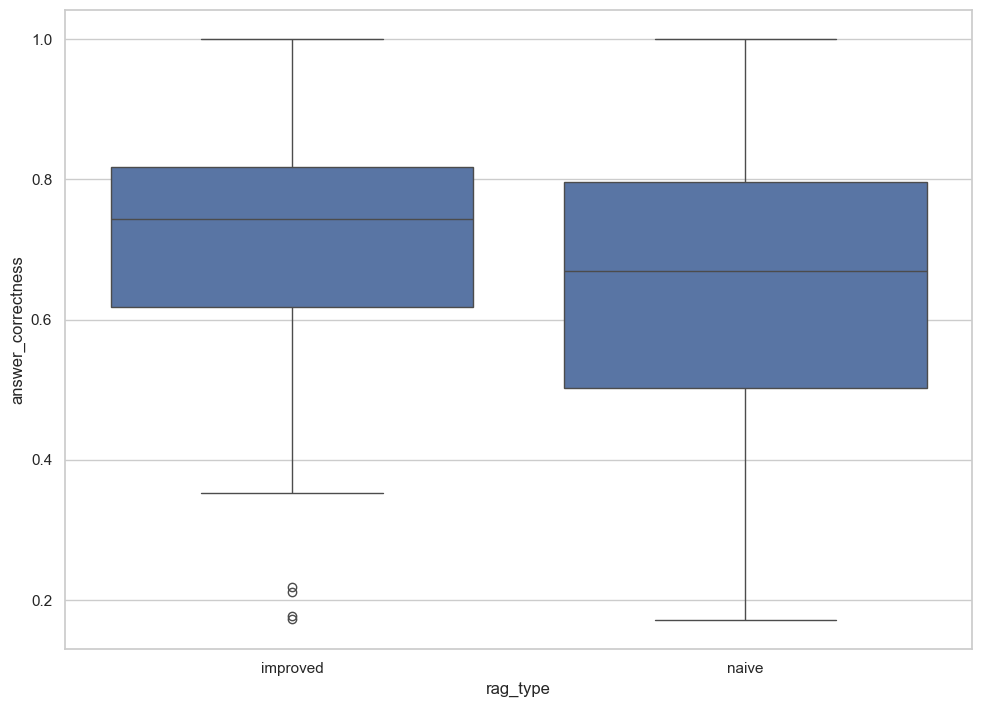

In [671]:
plt.figure(figsize=(11.7, 8.3))
box_plot=sns.boxplot(data=df_combined_result, x='rag_type', y="answer_correctness", orient='v')


##### Compare the number of questions for which Improved RAG outperformed Naive RAG (i.e. improved RAG achieved higher answer correctness score)

In [662]:
df_diff = df_naive_result.copy(deep=True)

In [663]:
# counter to track the number of times improved RAG outperformed naive RAG
num_improved_rag_performs_better = 0

for idx, question in enumerate(df_naive_result["question"]):
    
    naive_answer_correctness_score = df_naive_result.at[idx,"answer_correctness"]
    improved_answer_correctness_score = df_improved_result.at[idx,"answer_correctness"]
    diffScore = improved_answer_correctness_score - naive_answer_correctness_score 
    df_diff.loc[idx,"diffScore (= improved - naive)"] = diffScore
    if diffScore >= 0:
        num_improved_rag_performs_better = num_improved_rag_performs_better + 1

df_diff = df_diff[['question','diffScore (= improved - naive)']]

# given a dataframe of two columns, set the column as the index
df_diff.set_index("question", inplace=True)
df_diff

diffScore (= improved - naive)
question                                                                          
What criteria must a concrete mix meet to be cl...                        0.258193
What specific criteria must the Contractor chec...                       -0.087965
What are the differences between strain-softeni...                        0.000552
What are the requirements for conducting trial ...                        0.063884
What are the characteristics of the constant-dr...                        0.053618
...                                                                            ...
What magnification factor / eta_det / n_det fac...                        0.257044
How does magnification factor / eta_det / n_det...                       -0.079182
How do I calculate ULS bending moment?                                   -0.577324
Can the contribution of steel fibre reinforced ...                        0.015236
What design parameters can I adopt for design o...                       -0.239271

[69 rows x 1 columns]

In [664]:
print(f"total number of questions: {len(df_naive_result["question"])}")

print(f"number of questions for which improved RAG outperformed naive RAG: {num_improved_rag_performs_better}")
print(f"percentage of questions for which improved RAG outperformed naive RAG (i.e. improved RAG achieved higher answer correctness score): {(num_improved_rag_performs_better)/len(df_naive_result["question"]) * 100:.1f}%")

total number of questions: 69
number of questions for which improved RAG outperformed naive RAG: 46
percentage of questions for which improved RAG outperformed naive RAG (i.e. improved RAG achieved higher answer correctness score): 66.7%


Note: diffScore = answer correctness score (improved RAG) - answer correctness score (naive RAG); 
 a postive, orange value implies improved RAG outperformed naive RAG.


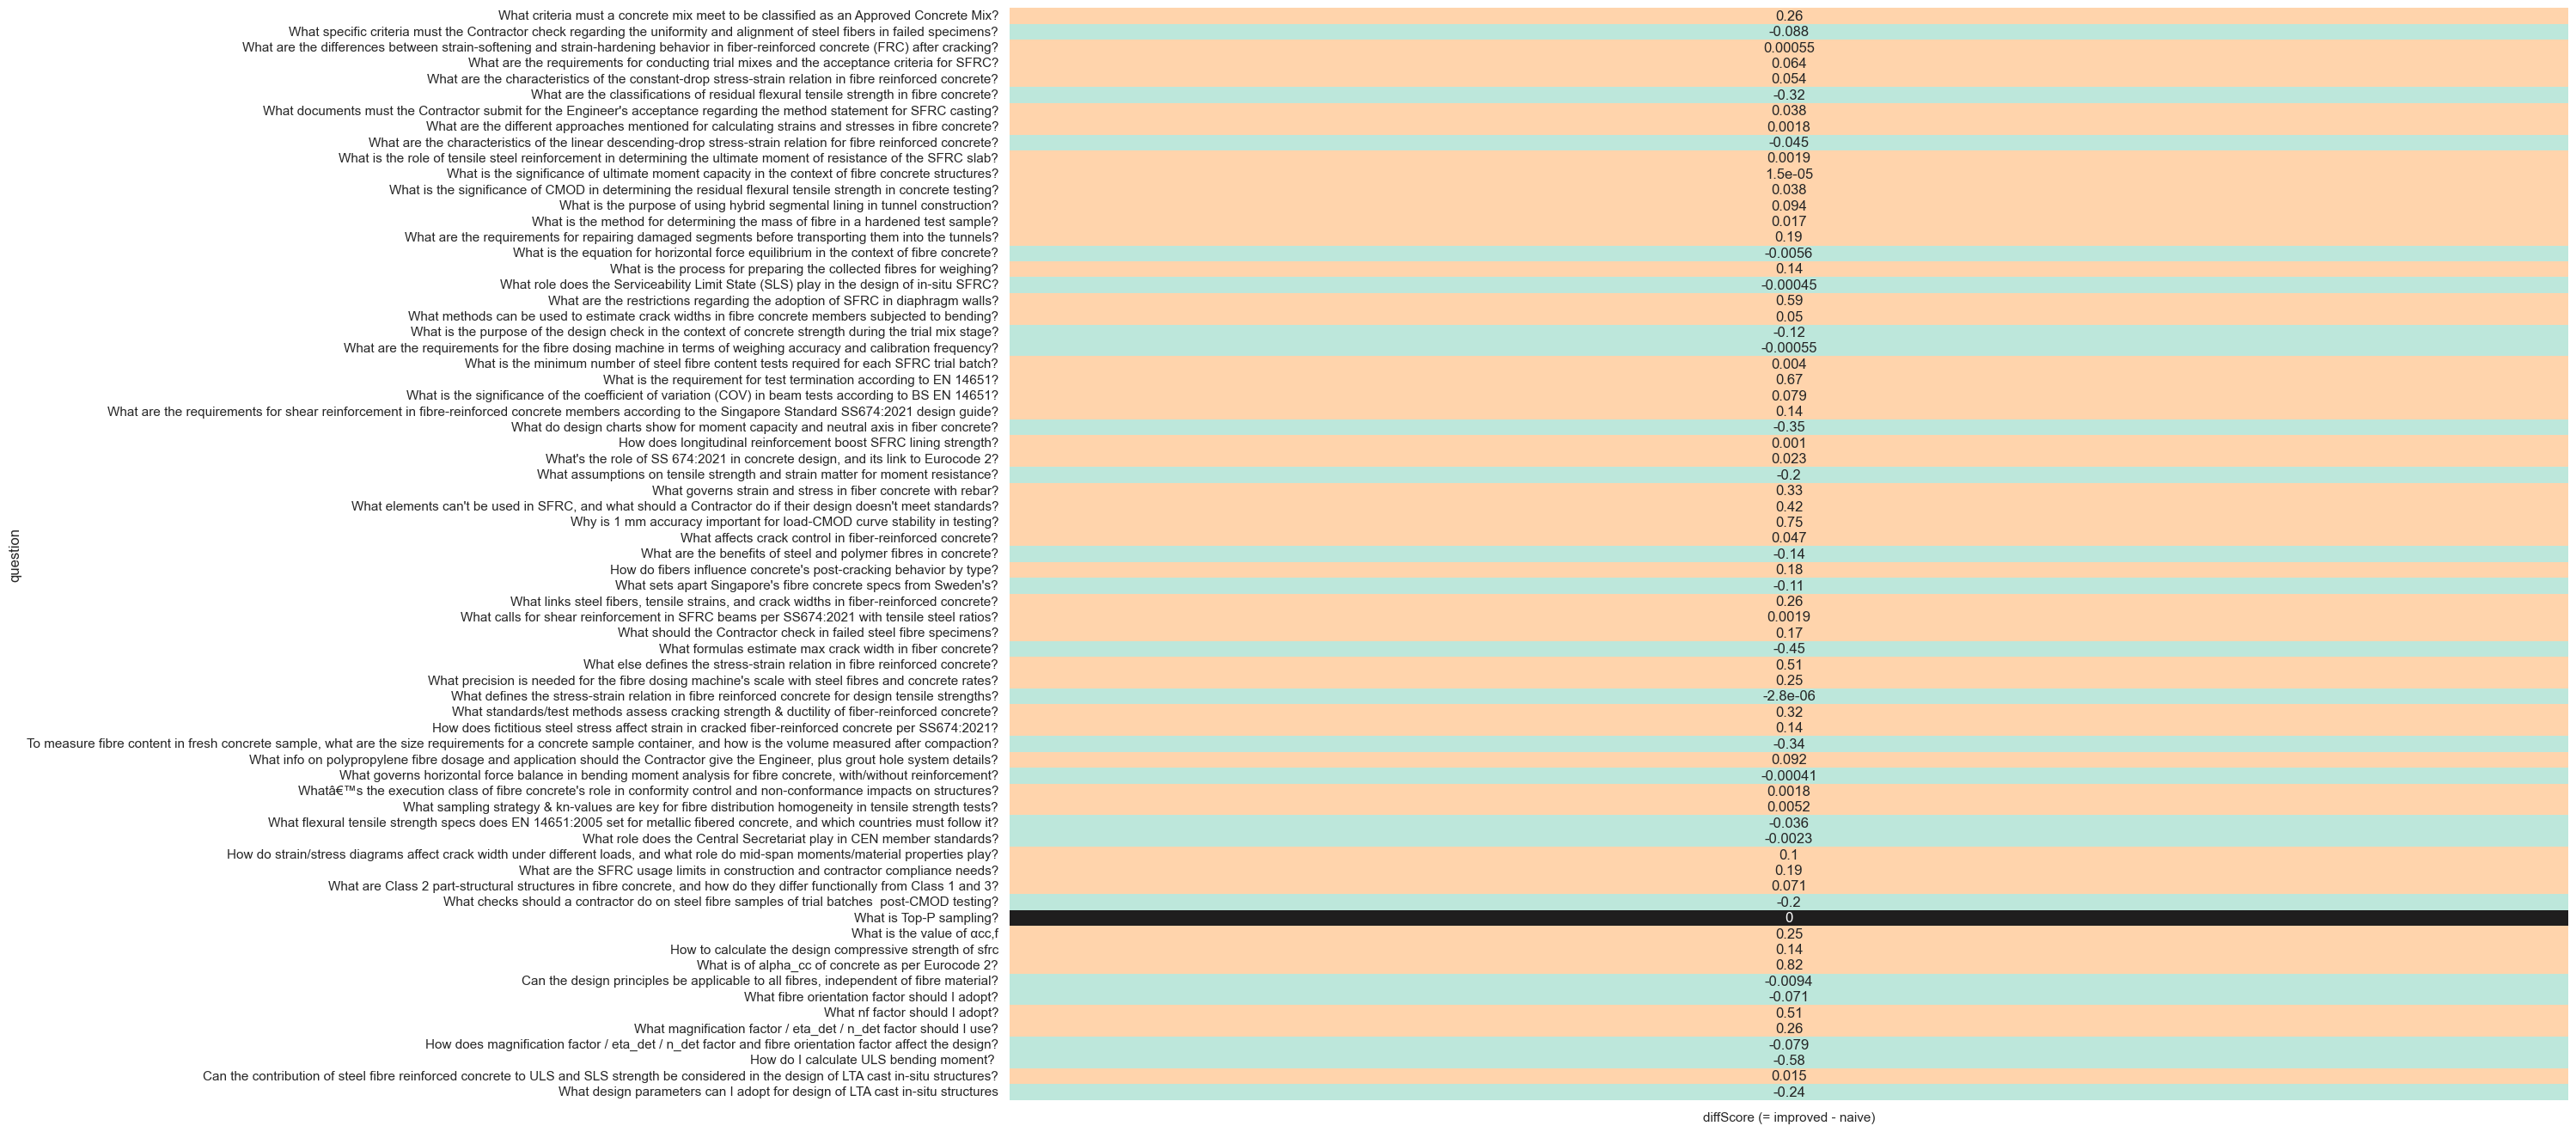

In [665]:
plt.figure(figsize=(23.4,16.5))
fig = sns.heatmap(df_diff, vmin=-0.000001, vmax=0.000001, cmap='icefire', xticklabels=True, yticklabels=True, annot=True, cbar=False)

print("Note: diffScore = answer correctness score (improved RAG) - answer correctness score (naive RAG); \n a postive, orange value implies improved RAG outperformed naive RAG.")

<Axes: xlabel='rag_type', ylabel='question'>

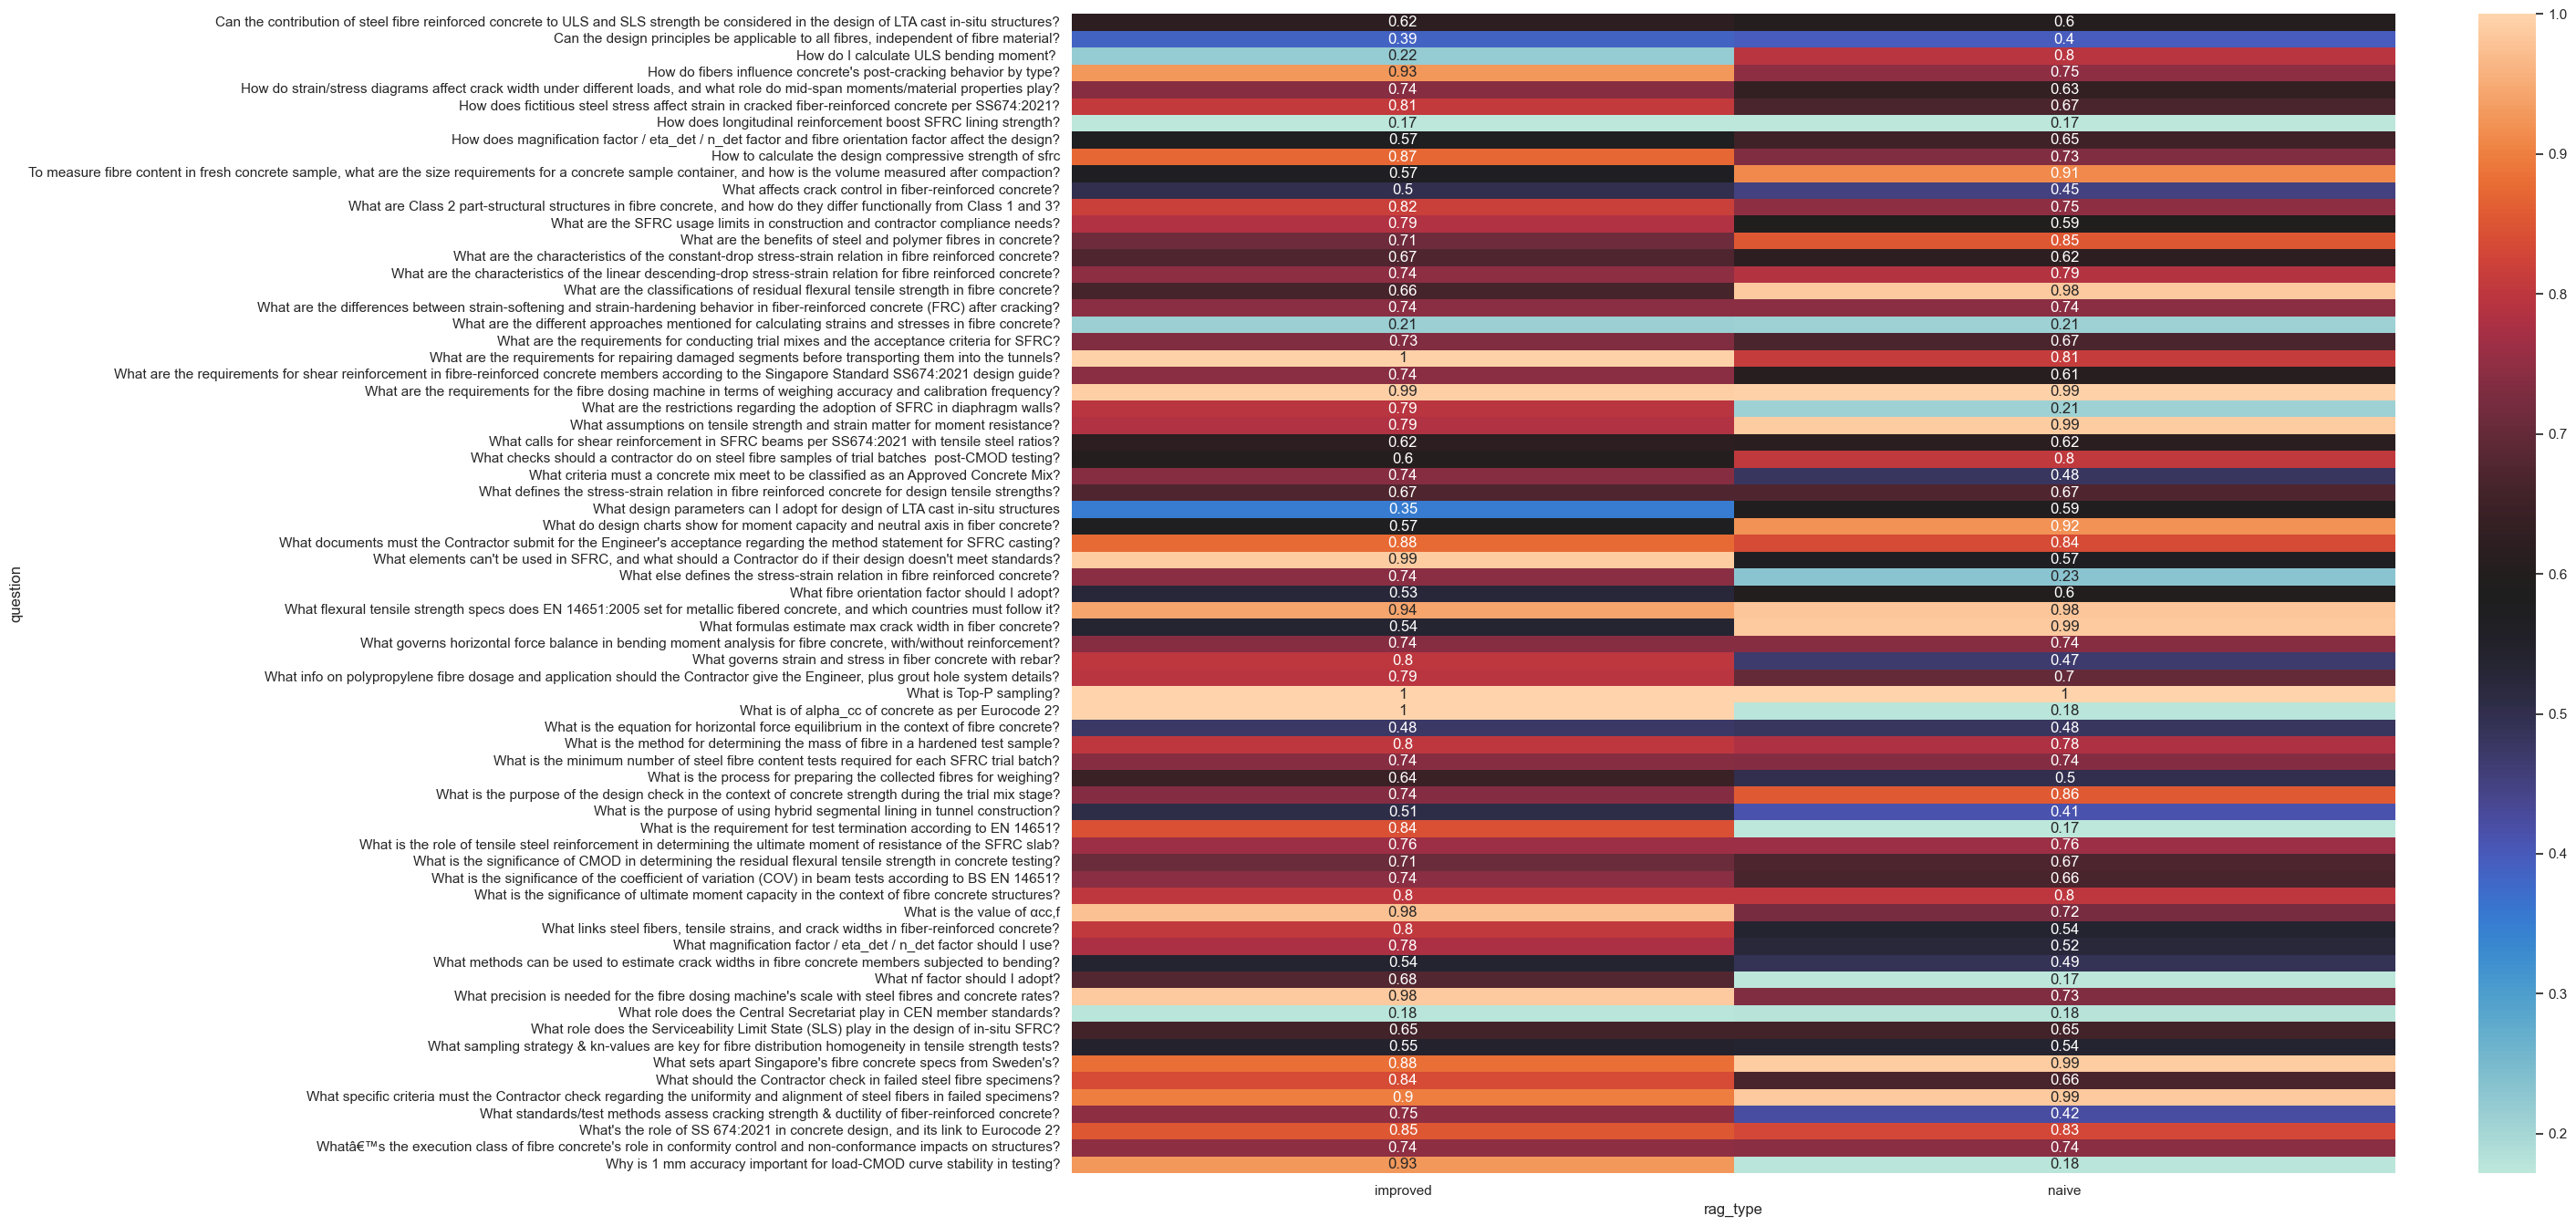

In [666]:
df_plot = df_combined_result[['question','rag_type','answer_correctness']]
plot_data = df_plot.pivot(index="question", columns="rag_type", values="answer_correctness")

plt.figure(figsize=(23.4,16.5))
sns.heatmap(plot_data, cmap='icefire', xticklabels=True, yticklabels=True, annot=True)

#### Error Anaylsis
1. Identify questions where Naive RAG perform better than Improved RAG 
2. Find out WHY

## References

https://playbooks.capdev.govtext.gov.sg/experiments/ <br> <br>

[GovTech .ipynb](../ref/week_05_answers.ipynb)